In [2]:
import kagglehub
import os
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt



/home/jordi/entornos/entorno_sic/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

#DataSet para reconocimiento de emociones
"""
    Este data set ayuda a reconocer seis emociones básicas
        sadness (0), joy (1), love (2), anger (3), fear (4), surprise(5)
    
    """
path = kagglehub.dataset_download("parulpandey/emotion-dataset")
df_1 = pd.read_csv('../data_sets/emotion_recognition1.csv')
df_2 = pd.read_csv('../data_sets/emotion_recognition2.csv')
df_3 = pd.read_csv('../data_sets/emotion_recognition3.csv')



In [4]:
print(df_1.head())
print(df_1['label'].unique())

                                                text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0
[0 1 4 3 2 5]


In [5]:
print(df_2.head())
print((df_2['label'].unique()))

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3
[0 3 2 5 4 1]


In [6]:
print(df_3.head())
print((df_3['label'].unique()))

                                                text  label
0  im feeling quite sad and sorry for myself but ...      0
1  i feel like i am still looking at a blank canv...      0
2                     i feel like a faithful servant      2
3                  i am just feeling cranky and blue      3
4  i can have for a treat or if i am feeling festive      1
[0 2 3 1 4 5]


In [7]:
df_emotions_recognition = pd.concat([df_1, df_2, df_3], ignore_index= True)
print(df_emotions_recognition.head())
print(df_emotions_recognition['label'].unique())

                                                text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0
[0 1 4 3 2 5]


In [8]:
#Cambiaremos el valor de las etiquetas
df_emotions_recognition = df_emotions_recognition.rename(columns={'text':'text','label':'emotion'})
df_emotions_recognition['emotion'] = df_emotions_recognition['emotion'].replace({0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'})
print(df_emotions_recognition.head())
print(df_emotions_recognition['emotion'].unique())
rows, columns = df_emotions_recognition.shape
print(f'Filas: {rows}\nColumnas: {columns} ')

                                                text  emotion
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness
['sadness' 'joy' 'fear' 'anger' 'love' 'surprise']
Filas: 20000
Columnas: 2 


In [9]:
"""
    Este data set, es una compilación de textos extraídos de reddit
    Estos textos indican depresión {1} y textos neutrales {0}
    """

path = kagglehub.dataset_download("infamouscoder/depression-reddit-cleaned")
df_depression = pd.read_csv('../data_sets/depression_dataset_reddit_cleaned.csv')
df_depression = df_depression.rename(columns={'clean_text': 'text', 'is_depression': 'emotion'})
df_depression['emotion'] = df_depression['emotion'].replace({0:'neutral',1:'depression'})
print(df_depression.head())
print(df_depression['emotion'].unique())
rows, columns = df_depression.shape
print(f'Filas: {rows}\nColumnas: {columns}')

                                                text     emotion
0  we understand that most people who reply immed...  depression
1  welcome to r depression s check in post a plac...  depression
2  anyone else instead of sleeping more when depr...  depression
3  i ve kind of stuffed around a lot in my life d...  depression
4  sleep is my greatest and most comforting escap...  depression
['depression' 'neutral']
Filas: 7731
Columnas: 2


In [12]:
#Para un entrenamiento generalizado, y así ajustar los parámetros del modelo de forma global
#Usaremos una amalgama como dataframes
#df = pd.concat([df_depression_detection,df_depression,df_emotions_recognition], ignore_index=True)
df = pd.concat([df_depression,df_emotions_recognition], ignore_index=True)

rows, columns = df.shape
print(f'Filas: {rows}\nColumnas: {columns}')
print(df.head())
print(df['emotion'].unique())

Filas: 27731
Columnas: 2
                                                text     emotion
0  we understand that most people who reply immed...  depression
1  welcome to r depression s check in post a plac...  depression
2  anyone else instead of sleeping more when depr...  depression
3  i ve kind of stuffed around a lot in my life d...  depression
4  sleep is my greatest and most comforting escap...  depression
['depression' 'neutral' 'sadness' 'joy' 'fear' 'anger' 'love' 'surprise']


In [13]:
#Definir funcion para procesamiento de data

def text_to_words (tweet):
    letters_only= re.sub("[^a-zA-Z]", " ", tweet) 
    words = letters_only.lower().split() 
    stops = set(stopwords.words("english")) 
    lemmatizer = WordNetLemmatizer()
    meaningful_words =[lemmatizer.lemmatize(w) for w in words if w not in stops]
    return(" ".join( meaningful_words ))

#Aplicamos las técnicas de PLN a los textos 
df['text'] = df['text'].apply(lambda x: text_to_words(x))
df['text']

0        understand people reply immediately op invitat...
1        welcome r depression check post place take mom...
2        anyone else instead sleeping depressed stay ni...
3        kind stuffed around lot life delaying inevitab...
4        sleep greatest comforting escape whenever wake...
                               ...                        
27726    im ssa examination tomorrow morning im quite w...
27727    constantly worry fight nature push limit inner...
27728           feel important share info experience thing
27729    truly feel passionate enough something stay tr...
27730    feel like wanna buy cute make see online even one
Name: text, Length: 27731, dtype: object

In [14]:
#Dividimos data en entrenamiento y testing
train, test = train_test_split(df, test_size=0.2, random_state=42)
#Concentramos la data en listas
train_clean_message = []
for message in train['text']:
    train_clean_message.append(message)

test_clean_message = []
for message in test['text']:
    test_clean_message.append(message)
#Vectorizamos la data
v = TfidfVectorizer()
train_features = v.fit_transform(train_clean_message)
test_features = v.transform(test_clean_message)

Accuracy of DecisionTreeClassifieris 0.8397331891112313
              precision    recall  f1-score   support

       anger       0.85      0.81      0.83       557
  depression       0.87      0.80      0.83       822
        fear       0.81      0.81      0.81       482
         joy       0.86      0.87      0.87      1358
        love       0.78      0.76      0.77       308
     neutral       0.80      0.87      0.83       709
     sadness       0.87      0.87      0.87      1168
    surprise       0.69      0.73      0.71       143

    accuracy                           0.84      5547
   macro avg       0.82      0.82      0.82      5547
weighted avg       0.84      0.84      0.84      5547



<Figure size 640x480 with 0 Axes>

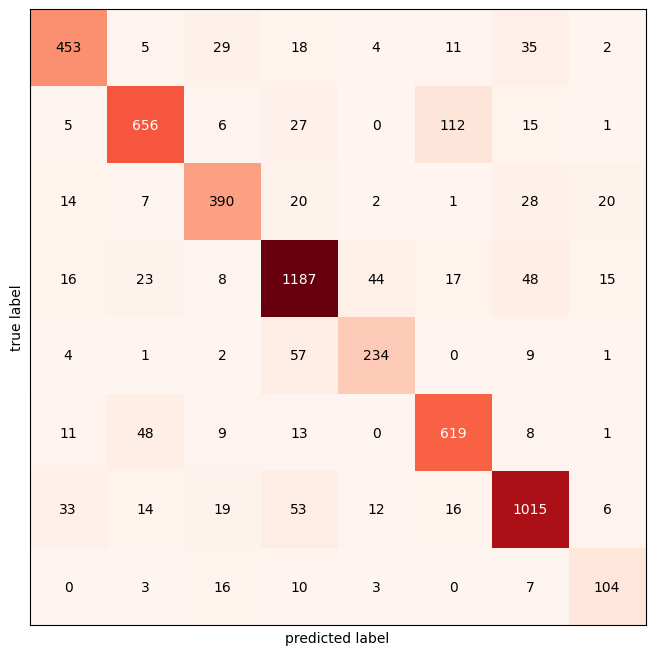

Accuracy of SVCis 0.8923742563547864
              precision    recall  f1-score   support

       anger       0.88      0.86      0.87       550
  depression       0.94      0.94      0.94       751
        fear       0.84      0.83      0.83       482
         joy       0.92      0.89      0.91      1423
        love       0.75      0.81      0.77       277
     neutral       0.93      0.90      0.91       799
     sadness       0.91      0.92      0.91      1142
    surprise       0.66      0.80      0.73       123

    accuracy                           0.89      5547
   macro avg       0.85      0.87      0.86      5547
weighted avg       0.89      0.89      0.89      5547



<Figure size 640x480 with 0 Axes>

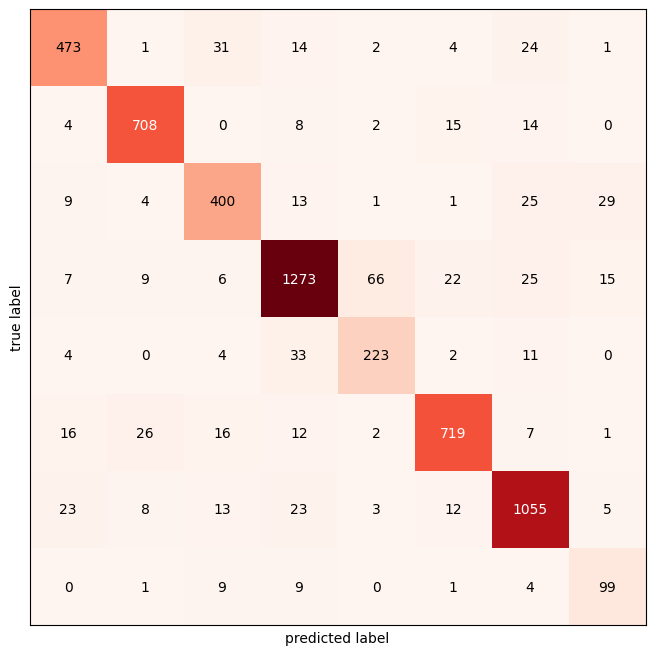

In [ ]:
#Entrenamos el modelo Cargado
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

DTCM1 =  DecisionTreeClassifier()
SVCM2 =  SVC(kernel='linear', random_state=42)

Classifiers = [
    DTCM1,
    SVCM2

]

dense_features = train_features.toarray()
dense_test = test_features.toarray()

Accuracy = []
Model = []

label_target = 'emotion'
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features, train[f'{label_target}'])
        pred = fit.predict(test_features)
    except:
        fit= classifier.fit(dense_features, train[f'{label_target}'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred, test[f'{label_target}'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+'is '+str(accuracy))
    print (classification_report (pred, test[f'{label_target}']))
    cm = confusion_matrix(pred, test[f'{label_target}'])
    plt.figure()
    plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Reds)
    plt.show()

In [ ]:
#Guardamos el modelo
joblib.dump(DTCM1, '../models/DTCM1.pkl')
joblib.dump(SVCM2, '../models/SVCM2.pkl')



['../models/SVCM2.pkl']

In [22]:
#Guardamos el vectorizador
joblib.dump(v, "../models/vectorizador.pkl")  # Guarda el vectorizador


['../models/vectorizador.pkl']

In [ ]:
#Híbrido de modelo, modelo con reglas
